In [1]:
import os
import numpy as np
from collections import defaultdict

import sys

sys.path.append("../2_train_models")
from data_loading import extract_peaks
from file_configs import MergedFilesConfig

sys.path.append("../5_modisco")
from modiscolite_utils import load_observed_profiles

import matplotlib.pyplot as plt

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# need to specify for every expt

patterns_to_keep = [0,1,2,3,4,5,6,7,8,9,13,15,19,21,23]

# This is specific to K562

motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA"]

In [3]:
cell_type = "K562"
model_type = "strand_merged_umap"
data_type = "procap"


timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

in_window = 2114
out_window = 1000

proj_dir = os.path.dirname(os.path.dirname(os.path.realpath(os.getcwd()))) + "/"

figures_dir = proj_dir + "figures/"

In [4]:
config = MergedFilesConfig(cell_type, model_type, data_type)

genome_path = config.genome_path
chrom_sizes = config.chrom_sizes

slice_len = config.slice

peak_path = config.all_peak_path

modisco_results_path = config.modisco_profile_results_path

scores_path = config.profile_onehot_scores_path

In [5]:
config.__dict__

{'cell_type': 'K562',
 'model_type': 'strand_merged_umap',
 'data_type': 'procap',
 'stranded_model': False,
 'umap': True,
 'proj_dir': '/mnt/lab_data2/kcochran/procapnet/',
 'genome_path': '/mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta',
 'chrom_sizes': '/mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.chrom.sizes',
 'mask_bw_path': '/mnt/lab_data2/kcochran/procapnet//annotations/hg38.k36.multiread.umap.bigWig',
 'data_dir': '/mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/',
 'all_peak_path': '/mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz',
 'plus_bw_path': '/mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/5prime.pos.bigWig',
 'minus_bw_path': '/mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/5prime.neg.bigWig',
 'slice': 1000,
 'pred_profiles_all_path': '/mnt/lab_data2/kcochran/procapnet/model_out/procap/K562/strand_merged_umap/merged/all_pred_profiles.npy',
 'pred_logcounts_all_path': '/mnt/lab

In [6]:
from motif_hits_utils import load_coords

coords = load_coords(peak_path, in_window=in_window)

In [7]:
from load_annotations_utils import find_peak_overlap_labels, get_ccre_bed

ccre_bed = get_ccre_bed(cell_type, proj_dir)

ccre_annots = find_peak_overlap_labels(coords, ccre_bed, in_window, out_window)

In [8]:
ccre_annots["PLS_no_pELS"] = ccre_annots["PLS"] * (~ ccre_annots["pELS"])
ccre_annots["PLS_with_pELS"] = ccre_annots["PLS"] * ccre_annots["pELS"]

In [9]:
onehot_seqs, true_profs = extract_peaks(genome_path,
                                        chrom_sizes,
                                        config.plus_bw_path,
                                        config.minus_bw_path,
                                        peak_path,
                                        in_window=in_window,
                                        out_window=out_window,
                                        max_jitter=0,
                                        verbose=True)

true_counts = true_profs.sum(axis=(1,2))  # strand-merged

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.10it/s]
Loading Peaks: 30534it [00:40, 748.55it/s]


== In Extract Peaks ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Sequence length (with jitter): 2114
Profile length (with jitter): 1000
Max jitter applied: 0
Num. Examples: 30534
Mask loaded? False


In [10]:
pred_profs = np.exp(np.load(config.pred_profiles_all_path))
pred_counts = np.exp(np.load(config.pred_logcounts_all_path)).squeeze()

PLS_with_pELS
Pred. vs. Obs. MSE: 0.47790864
Pred vs. Obs Pearson r: 0.556340096106588
Pred vs. Obs Spearman r: 0.5366944224433973

PLS_no_pELS
Pred. vs. Obs. MSE: 1.0471004
Pred vs. Obs Pearson r: 0.4915545067020761
Pred vs. Obs Spearman r: 0.5520372667725453

dELS
Pred. vs. Obs. MSE: 0.77226824
Pred vs. Obs Pearson r: 0.6442797179443545
Pred vs. Obs Spearman r: 0.6099997673971393



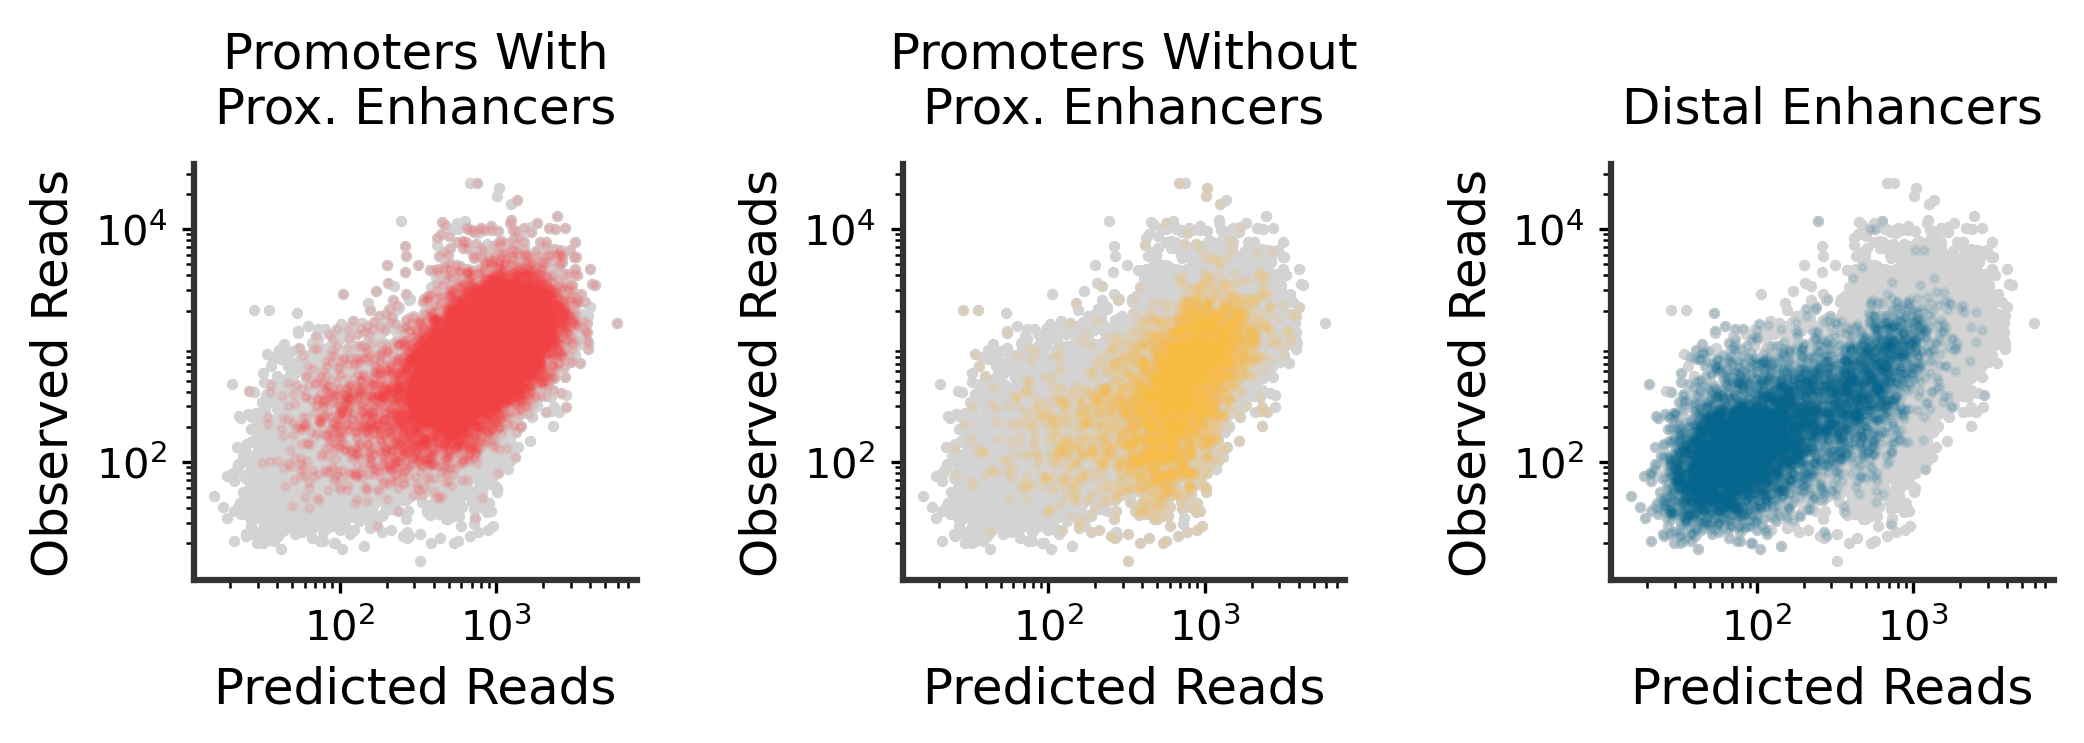

In [17]:
from matplotlib import ticker as mticker
from scipy.stats import spearmanr


# use the version in Figure 1's notebook instead


def plot_true_pred_counts_by_annot(true_counts, pred_counts, overlap_annots_bools,
                                   save_path = None):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers",
                        "PLS_with_pELS" : "Promoters With\nProx. Enhancers",
                        "PLS_no_pELS" : "Promoters Without\nProx. Enhancers" }
    
    annots_to_colors = {"PLS" : "#f94144",
                        "pELS" : "#ffbc42",
                        "dELS" : "#05668d",
                        "PLS_with_pELS" : "#f94144",
                        "PLS_no_pELS" : "#ffbc42"}
    
    fig, axes = plt.subplots(1,3,figsize=(8,1.8), dpi=300)
    
    annots_to_plot = ["PLS_with_pELS", "PLS_no_pELS", "dELS"] #["PLS", "pELS", "dELS"]
    
    all_x = []
    all_y = []
    for annot_name in annots_to_plot:
        all_x.extend(pred_counts[overlap_annots_bools[annot_name]])
        all_y.extend(true_counts[overlap_annots_bools[annot_name]])
    
    for ax, sup_annot_name in zip(axes, annots_to_plot):
        ax.scatter(all_x, all_y, alpha = 1, s = 3,
                    label = "Other", color = "lightgray")
        
        # have to plot last
        true_counts_subset = true_counts[overlap_annots_bools[sup_annot_name]]
        pred_counts_subset = pred_counts[overlap_annots_bools[sup_annot_name]]
        
        mse = np.mean((np.log1p(pred_counts_subset) - np.log1p(true_counts_subset)) ** 2)
        print(sup_annot_name)
        print("Pred. vs. Obs. MSE:", mse)
        print("Pred vs. Obs Pearson r:", np.corrcoef(np.log(pred_counts_subset),
                                                     np.log(true_counts_subset))[0,1])
        print("Pred vs. Obs Spearman r:", spearmanr(np.log(pred_counts_subset),
                                                    np.log(true_counts_subset)).correlation)
        
        print("")
        
        ax.scatter(pred_counts_subset, true_counts_subset, alpha = 0.1, s = 3,
                    label = annots_to_labels[sup_annot_name],
                    color = annots_to_colors[sup_annot_name])

        ax.semilogy()
        ax.semilogx()

        ax.set_xlabel("Predicted Reads", fontsize = 12)
        ax.set_ylabel("Observed Reads", fontsize = 12)

        ax.spines["left"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        ax.spines["bottom"].set_color("#333333")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        #ax.xaxis.set_ticks_position('none') 
        #ax.yaxis.set_ticks_position('none')
        ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        ax.tick_params(axis='both', labelsize=10, length=3)
        
        ax.set_title(annots_to_labels[sup_annot_name], fontsize=12, pad=10)

    plt.subplots_adjust(wspace=0.6)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()

    
plot_true_pred_counts_by_annot(true_counts, pred_counts, ccre_annots),
                               #save_path = figures_dir + "S1_counts_by_ccre.png")

In [12]:
mse = np.mean((np.log1p(pred_counts) - np.log1p(true_counts)) ** 2)
mse

0.7406893

In [13]:
mse = np.mean((np.log1p(pred_counts[ccre_annots["PLS"]]) - np.log1p(true_counts[ccre_annots["PLS"]])) ** 2)
mse

0.58798814

In [25]:
from BPNet_strand_merged_umap import Model
import torch
from file_configs import FoldFilesConfig
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "GPU-37e6e660-d7d1-52e9-9f59-d3fa20a33989"


# re-define the model's forward func so that it returns output of intermediate layer

class BPNet_Embeddings_Loader(Model):
    def __init__(self, n_filters=512, n_layers=8, trimming=(in_window - out_window) // 2,
                 alpha=100):
        super().__init__("", n_filters=n_filters, n_layers=n_layers, trimming=trimming,
                         alpha=alpha)

    def forward(self, X):
        start, end = self.trimming, X.shape[2] - self.trimming

        X = self.relus[0](self.iconv(X))

        for i in range(self.n_layers):
            X_conv = self.relus[i+1](self.rconvs[i](X))
            X = torch.add(X, X_conv)
            
        X = X[:, :, start - self.deconv_kernel_size//2 : end + self.deconv_kernel_size//2]

        # return result of global avg pooling
        # (beginning of counts head, before linear layer)
        X = torch.mean(X, axis=2)
        return X
    
    
def get_embeddings(embedder, seqs, batch_size=128):
    if not seqs.shape[-2] == 4:
        seqs = np.swapaxes(seqs, -2, -1)
    seqs = torch.tensor(seqs, dtype=torch.float)
    embedder = embedder.cuda()
    with torch.no_grad():
        starts = np.arange(0, seqs.shape[0], batch_size)
        ends = starts + batch_size

        embeds = []
        for i, (start, end) in enumerate(zip(starts, ends)):
            if i % 50 == 0:
                print("Batch " + str(i) + " of " + str(len(starts)))
            
            seqs_batch = seqs[start:end]
            embeds_batch = embedder(seqs_batch.cuda()).cpu().detach().numpy()
            embeds.append(embeds_batch)

    embedder = embedder.cpu()
    return np.concatenate(embeds)

def get_embeddings_all_folds(timestamps, seqs):
    embeddings_all_folds = []
    
    for timestamp in timestamps:
        fold_config = FoldFilesConfig(cell_type, model_type, "1", timestamp, data_type)
        
        embedder = BPNet_Embeddings_Loader()
        model = torch.load(fold_config.model_save_path)
        embedder.load_state_dict(model.state_dict())
        embedder.eval()
        embedder = embedder.cuda()
        
        embeddings_all_folds.append(get_embeddings(embedder, seqs))
        
    return np.array(embeddings_all_folds).mean(axis=0)

In [26]:
peak_embeds = get_embeddings_all_folds(timestamps, onehot_seqs)

Timestamp: 2023-05-29_15-51-40
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_15-58-41
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_15-59-09
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-30_01-40-06
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_23-21-23
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_23-23-45
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_23-24-11
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239


In [27]:
peak_embeds.shape

(30534, 512)

In [28]:
promoter_embeds = peak_embeds[ccre_annots["PLS"]]
promoters_with_pELS_embeds = peak_embeds[ccre_annots["PLS"] * ccre_annots["pELS"]]
promoters_no_pELS_embeds = peak_embeds[ccre_annots["PLS"] * (~ ccre_annots["pELS"])]
d_enhancer_embeds = peak_embeds[ccre_annots["dELS"]]

print(len(promoter_embeds), len(promoters_with_pELS_embeds), len(promoters_no_pELS_embeds), len(d_enhancer_embeds))

16960 13680 3280 5648


In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pcs = pca.fit(peak_embeds)
promoter_pcs = pca.transform(promoter_embeds)
d_enhancer_pcs = pca.transform(d_enhancer_embeds)
promoters_with_pELS_pcs = pca.transform(promoters_with_pELS_embeds)
promoters_no_pELS_pcs = pca.transform(promoters_no_pELS_embeds)

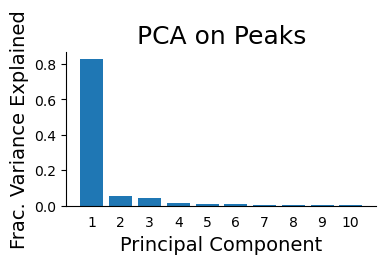

In [30]:
plt.figure(figsize=(4,2))
plt.bar(range(1, 10+1), pca.explained_variance_ratio_)
plt.xlabel("Principal Component", fontsize = 14)
plt.ylabel("Frac. Variance Explained", fontsize = 14)
plt.title("PCA on Peaks", fontsize = 18)

plt.xticks(range(1, 10+1))
for side in ["right", "top"]:
    plt.gca().spines[side].set_visible(False)
plt.gca().xaxis.set_ticks_position('none') 

plt.show()

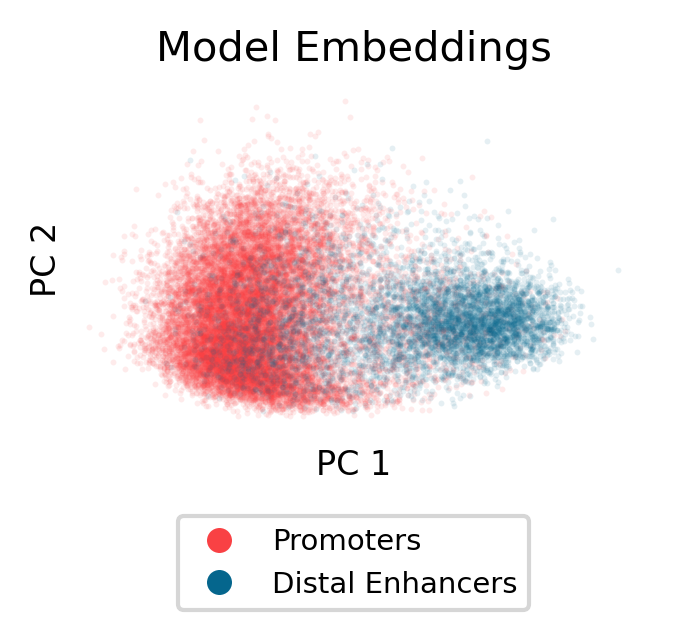

In [31]:
from matplotlib.lines import Line2D

def plot_embeds_pca(promoter_pcs, d_enhancer_pcs, save_path = None):
    plt.figure(figsize=(2.5,1.5), dpi=300)

    plt.scatter(promoter_pcs[..., 0], promoter_pcs[..., 1],
                alpha = 0.1, s = 2, c="#f94144", linewidths=0)
    plt.scatter(d_enhancer_pcs[..., 0], d_enhancer_pcs[..., 1],
                alpha = 0.1, s = 2, c="#05668d", linewidths=0)

    plt.xlabel("PC 1", fontsize = 8)
    plt.ylabel("PC 2", fontsize = 8, labelpad=0)
    plt.title("Model Embeddings", fontsize = 10)

    for side in ["right", "top", "bottom", "left"]:
        plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params("both", length=0)


    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Promoters',
                              markerfacecolor="#f94144", markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='Distal Enhancers',
                              markerfacecolor="#05668d", markersize=7)]

    plt.legend(handles=legend_elements, fontsize = 7,
               loc='upper center', bbox_to_anchor = (0.5, -0.2))

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    
plot_embeds_pca(promoter_pcs, d_enhancer_pcs, save_path = figures_dir + "4A_embeds.png")

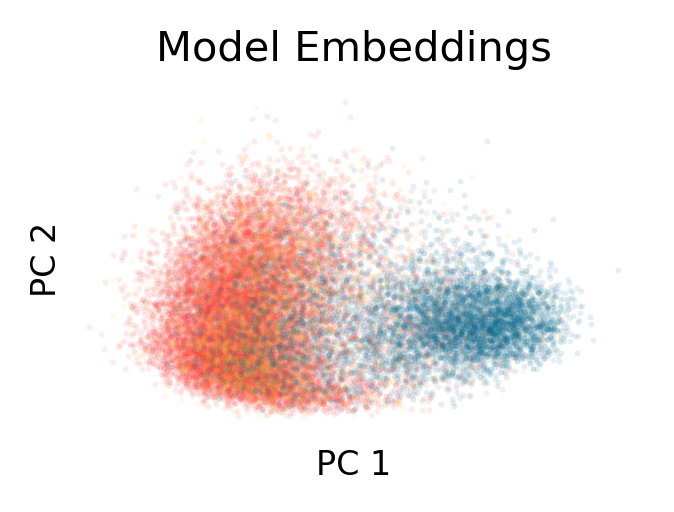

In [32]:
# promoters with vs. without pELS don't really separate

from matplotlib.lines import Line2D

def plot_embeds_pca2(promoter_pcs1, promoter_pcs2, d_enhancer_pcs, save_path = None):
    plt.figure(figsize=(2.5,1.5), dpi=300)

    plt.scatter(promoter_pcs1[..., 0], promoter_pcs1[..., 1],
                alpha = 0.1, s = 2, c="#f94144", linewidths=0)
    plt.scatter(promoter_pcs2[..., 0], promoter_pcs2[..., 1],
                alpha = 0.1, s = 2, c="#ffbc42", linewidths=0)
    plt.scatter(d_enhancer_pcs[..., 0], d_enhancer_pcs[..., 1],
                alpha = 0.1, s = 2, c="#05668d", linewidths=0)

    plt.xlabel("PC 1", fontsize = 8)
    plt.ylabel("PC 2", fontsize = 8, labelpad=0)
    plt.title("Model Embeddings", fontsize = 10)

    for side in ["right", "top", "bottom", "left"]:
        plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params("both", length=0)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    
plot_embeds_pca2(promoters_with_pELS_pcs, promoters_no_pELS_pcs,
                d_enhancer_pcs)

In [36]:
def inverse_hist(profile):
    assert len(profile.shape) == 1 or (len(profile.shape) == 2 and profile.shape[0] == 2), profile.shape

    profile = profile.sum(axis=0).astype(int)
    return np.repeat(range(len(profile)), profile)

def get_variances(profiles):
    return np.array([np.var(inverse_hist(profile)) for profile in profiles])

variances = get_variances(true_profs)

In [35]:
from common_functions import get_orientation_indexes

ois = get_orientation_indexes(true_profs)

promoter_ois = ois[ccre_annots["PLS"]]
p_enhancer_ois = ois[ccre_annots["pELS"]]
d_enhancer_ois = ois[ccre_annots["dELS"]]

In [37]:
promoter_vars = variances[ccre_annots["PLS"]]
p_enhancer_vars = variances[ccre_annots["pELS"]]
d_enhancer_vars = variances[ccre_annots["dELS"]]

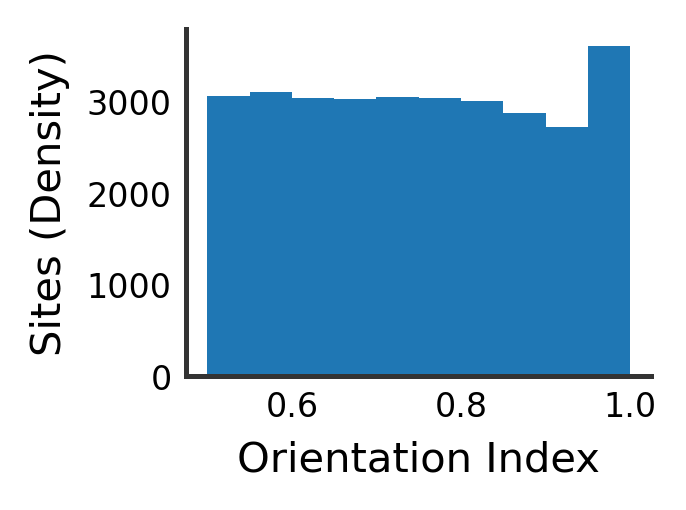

In [38]:
plt.figure(figsize=(2,1.5), dpi=300)

plt.hist(ois)

plt.xlabel("Orientation Index", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

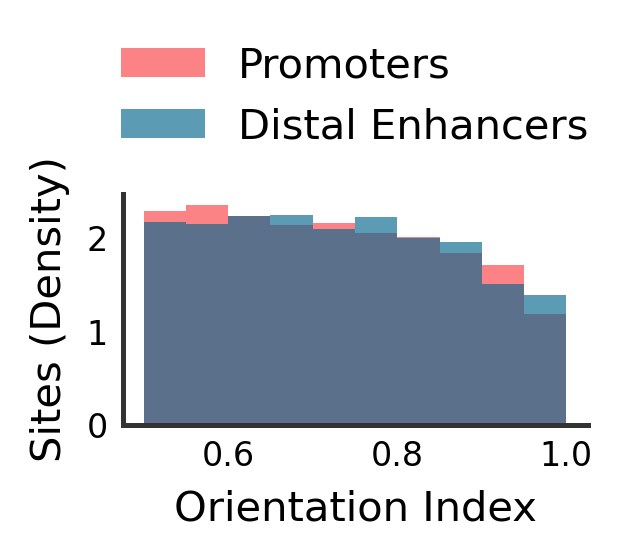

In [39]:
plt.figure(figsize=(2,1), dpi=300)

plt.hist(promoter_ois, density=True, alpha=0.65, label="Promoters", color="#f94144")
plt.hist(d_enhancer_ois, density=True, alpha=0.65, label="Distal Enhancers", color="#05668d")

plt.xlabel("Orientation Index", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)
plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

In [40]:
from common_functions import get_norm_shannon_entropies

norm_shannon_entropies = get_norm_shannon_entropies(true_profs, true_counts)
promoter_nses = norm_shannon_entropies[ccre_annots["PLS"]]
enhancer_nses = norm_shannon_entropies[ccre_annots["dELS"]]

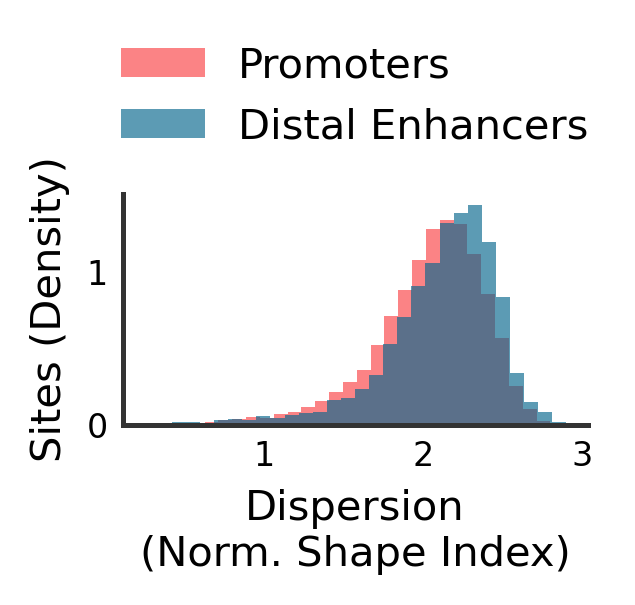

In [41]:
plt.figure(figsize=(2,1), dpi=300)

plt.hist(promoter_nses, density=True, alpha=0.65, label="Promoters", color="#f94144", bins=30)
plt.hist(enhancer_nses, density=True, alpha=0.65, label="Distal Enhancers", color="#05668d", bins=30)

plt.xlabel("Dispersion\n(Norm. Shape Index)", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)
plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

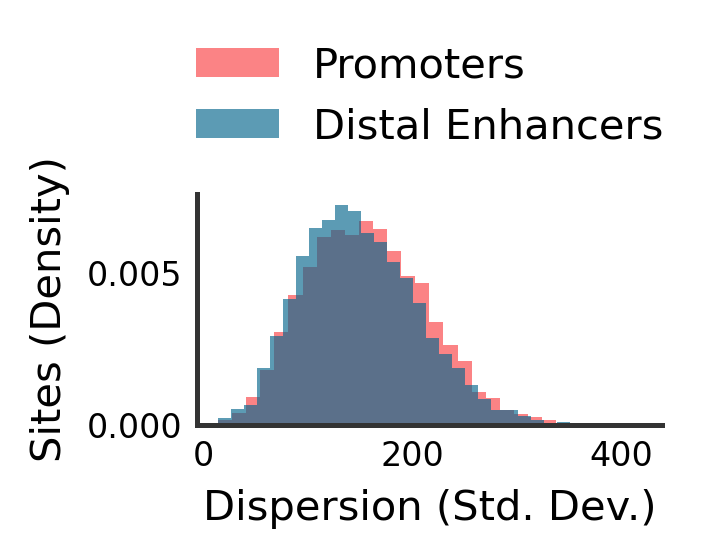

In [42]:
plt.figure(figsize=(2,1), dpi=300)

plt.hist(np.sqrt(promoter_vars), density=True, alpha=0.65, label="Promoters", color="#f94144", bins=30)
plt.hist(np.sqrt(d_enhancer_vars), density=True, alpha=0.65, label="Distal Enhancers", color="#05668d", bins=30)

plt.xlabel("Dispersion (Std. Dev.)", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)
plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

In [43]:
### Load Motifs

from motif_hits_utils import load_motif_hits

motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(cell_type, model_type, data_type,
                                                                 in_window=in_window)

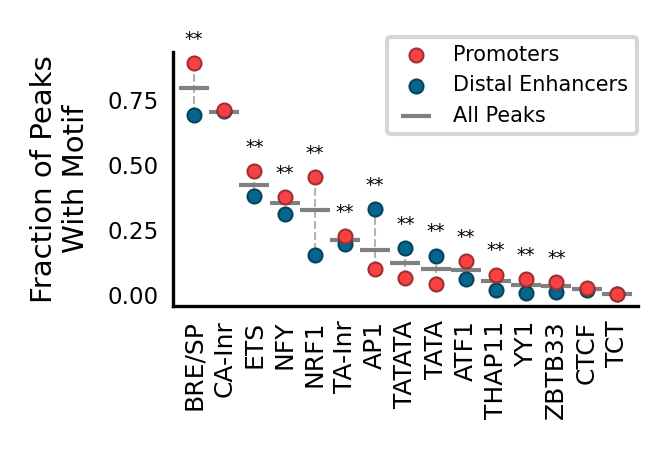

In [50]:
from collections import defaultdict
import scipy
import scipy.stats

def perm_test_diff_motif_fracs(pls_motifs, dels_motifs):
    return np.mean(pls_motifs) - np.mean(dels_motifs)



def plot_motif_enrichment_in_cCREs_condensed(peak_hit_counts, overlap_annots_bools,
                                        annots_to_plot = ["PLS", "dELS"],
                                        motif_keys_to_labels = motif_names,
                                            save_path = None):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}
    annots_to_edgecolors = {"All Peaks" : "gray", "PLS" : "#A12F31", "dELS" : "#05435C"}
    annots_to_sizes = {"All Peaks" : 50, "PLS" : 45, "dELS" : 45}
    
    annot_vals = defaultdict(lambda : [])
    pvals = []
    
    assert len(motif_keys_to_labels) == peak_hit_counts.shape[1]
    
    motif_keys = range(len(motif_keys_to_labels))
    for motif_index in motif_keys:
        total_peaks_with_motif = np.sum(peak_hit_counts[:, motif_index] > 0)

        for key in annots_to_plot:
            overlap_peaks = np.sum(overlap_annots_bools[key])
            overlap_peaks_with_motif = np.sum(peak_hit_counts[overlap_annots_bools[key], motif_index] > 0)

            annot_vals[key].append(overlap_peaks_with_motif / overlap_peaks)
            
        # sorry hardcoding it
        mwu_pval = scipy.stats.permutation_test((peak_hit_counts[ccre_annots["PLS"], motif_index],
                                                 peak_hit_counts[ccre_annots["dELS"], motif_index]),
                                                perm_test_diff_motif_fracs, n_resamples=9999).pvalue
        
        if mwu_pval <= 2e-4:
            pvals.append("**")
        elif mwu_pval < 0.01:
            pvals.append("*")
        else:
            pvals.append(" ")
            
        annot_vals["All Peaks"].append(total_peaks_with_motif / peak_hit_counts.shape[0])

    plot_order = np.argsort(annot_vals["All Peaks"])[::-1]
        
    plt.figure(figsize=(2.0, 1.1), dpi=300)
    
    add_to_legend = True
    for y, plot_i in enumerate(plot_order):
        plt.plot([y] * 2,
                 [annot_vals["PLS"][plot_i], annot_vals["dELS"][plot_i]],
                 color="gray", alpha = 0.6, linewidth=0.5, linestyle="dashed")
        
        plt.text(y, 0.07 + max(annot_vals["PLS"][plot_i], annot_vals["dELS"][plot_i]),
                 pvals[plot_i],
                 fontsize=4.5, horizontalalignment="center")
        
        for i, (key, vals) in enumerate(annot_vals.items()):
            if key == "All Peaks":
                plt.scatter(y, vals[plot_i],
                            label=key if add_to_legend else "",
                            color=annots_to_colors[key],
                            linewidth=1,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker="_")
            else:
                plt.scatter(y, vals[plot_i],
                            label=annots_to_labels[key] if add_to_legend else "",
                            color=annots_to_colors[key],
                            edgecolor=annots_to_edgecolors[key],
                            linewidth=0.5,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker=".")
            
        add_to_legend = False

    plt.legend(fontsize=5, loc="upper right", bbox_to_anchor=(1.02, 1.1))
    plt.xticks(motif_keys, np.array(motif_keys_to_labels)[plot_order],
               fontsize=6, rotation=90)
    plt.tick_params(left=False, length=0)
    plt.yticks([0.0, 0.25, 0.5, 0.75], fontsize=5.5)
    plt.ylabel("Fraction of Peaks\nWith Motif", fontsize=7)
    
    plt.gca().spines[["top", "right"]].set_visible(False)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    
plot_motif_enrichment_in_cCREs_condensed(motif_hit_counts["profile"], ccre_annots,
                                        save_path = figures_dir + "4C_ccre_motif_fracs.png")

In [51]:
np.sum(ccre_annots["PLS"]), np.sum(ccre_annots["dELS"]), np.sum(np.logical_or(ccre_annots["PLS"], ccre_annots["dELS"]))


(16960, 5648, 22608)

In [53]:
from sklearn.linear_model import LogisticRegression

tmp_data_idxs = np.logical_or(ccre_annots["PLS"], ccre_annots["dELS"])
tmp_X = motif_hit_counts["profile"][tmp_data_idxs]
tmp_y = ccre_annots["PLS"][tmp_data_idxs]

lrm = LogisticRegression(penalty='none').fit(tmp_X, tmp_y)

# accuracy of LR classifier on promoter vs. enhancer
print(lrm.score(tmp_X, tmp_y))

0.8190021231422505


In [54]:
for motif_i, motif_name in enumerate(motif_names):
    print(motif_name, "%0.3f" % (lrm.coef_.squeeze()[motif_i]))

BRE/SP 0.317
CA-Inr 0.112
ETS 0.419
NFY 0.370
NRF1 0.907
ATF1 0.760
TATA -0.723
THAP11 1.259
YY1 1.872
AP1 -0.880
TA-Inr 0.148
CTCF 0.024
ZBTB33 1.364
TCT 0.522
TATATA -0.523


In [55]:
lrm2 = LogisticRegression(penalty='none').fit(tmp_X > 0, tmp_y)

# accuracy of LR classifier on promoter vs. enhancer
print(lrm2.score(tmp_X > 0, tmp_y))

for motif_i, motif_name in enumerate(motif_names):
    print(motif_name, "%0.3f" % (lrm2.coef_.squeeze()[motif_i]))

0.8003361641896674
BRE/SP 1.148
CA-Inr 0.087
ETS 0.415
NFY 0.431
NRF1 1.327
ATF1 0.743
TATA -0.964
THAP11 1.512
YY1 2.021
AP1 -1.159
TA-Inr 0.139
CTCF 0.068
ZBTB33 1.468
TCT 0.600
TATATA -0.701


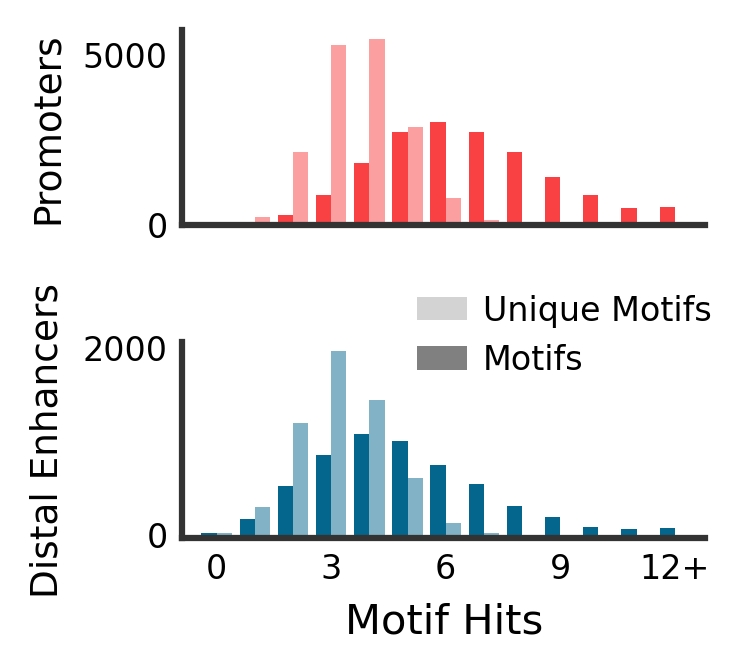

In [64]:
from matplotlib.patches import Patch


def plot_motif_complexity_across_ccres(motif_hit_counts, ccre_annots, annots_to_plot = ["PLS", "dELS"],
                                      save_path = None):
    bar_width = 0.4
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    
    fig, axes = plt.subplots(2, 1, figsize=(2.25,2.2), dpi=300, sharex=True)
    fig.subplots_adjust(hspace=0.6)
    
    for ax_i, key in enumerate(annots_to_plot):
        motif_hit_counts_annot = motif_hit_counts[ccre_annots[key]]
        
        # total motif hits
        
        motif_hits_per_peak = motif_hit_counts_annot.sum(axis=1)

        hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))

        stop_point = 12
        hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
        hist_x = list(hist_x[:stop_point]) + [stop_point]

        uniq_hits_per_peak = (motif_hit_counts_annot > 0).sum(axis=1)

        hist_y2, hist_x2 = np.histogram(uniq_hits_per_peak, bins=range(np.max(uniq_hits_per_peak) + 2))
        
        
        
        axes[ax_i].bar(hist_x, hist_y, color=annots_to_colors[key], width=bar_width)
        axes[ax_i].bar(hist_x2[:-1] + bar_width, hist_y2, color=annots_to_colors[key], width=bar_width, alpha=0.5)

        
        axes[ax_i].set_ylabel(annots_to_labels[key], fontsize=9)
        
        if ax_i == len(annots_to_plot) - 1:
            axes[ax_i].set_xlabel("Motif Hits", fontsize=10)
        
            xticklabels = []
            for i in hist_x:
                if i < stop_point:
                    xticklabels.append(str(i))
                else:
                    xticklabels.append(str(stop_point) + "+")

            axes[ax_i].set_xticks(np.array(hist_x[::3]) + bar_width / 2, xticklabels[::3])
            axes[ax_i].set_xlim(-0.7, len(hist_x))
            
            axes[ax_i].set_ylim(-30, axes[ax_i].get_ylim()[1])
            
        axes[ax_i].tick_params("both", labelsize=8, length=0)

        axes[ax_i].spines[["left", "bottom"]].set_linewidth(1.5)
        axes[ax_i].spines[["left", "bottom"]].set_color("#333333")
        axes[ax_i].spines[["top", "right"]].set_visible(False)


    legend_elements = [Patch(facecolor='lightgray', label='Unique Motifs'),
                       Patch(facecolor='gray', label='Motifs')]

    axes[-1].legend(handles=legend_elements, fontsize=8, bbox_to_anchor=(0,0,1.07,1.4),
                   loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
            
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()


plot_motif_complexity_across_ccres(motif_hit_counts["profile"], ccre_annots,
                                  save_path = figures_dir + "4C_ccre_complexity.png")

In [44]:
scipy.stats.mannwhitneyu(motif_hit_counts["profile"][ccre_annots["PLS"]].sum(axis=-1),
                         motif_hit_counts["profile"][ccre_annots["dELS"]].sum(axis=-1)).pvalue

0.0

In [45]:
scipy.stats.mannwhitneyu((motif_hit_counts["profile"][ccre_annots["PLS"]] > 0).sum(axis=-1),
                         (motif_hit_counts["profile"][ccre_annots["dELS"]] > 0).sum(axis=-1)).pvalue

8.104330501947292e-142

In [65]:
from data_loading import one_hot_encode
from modiscolite_utils import load_sequences

onehot_seqs = load_sequences(genome_path,
                             chrom_sizes,
                             peak_path,
                             slice_len=slice_len,
                             in_window=in_window)

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta
== In Extract Sequences ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Sequence length: 2114
Num. Examples: 30534


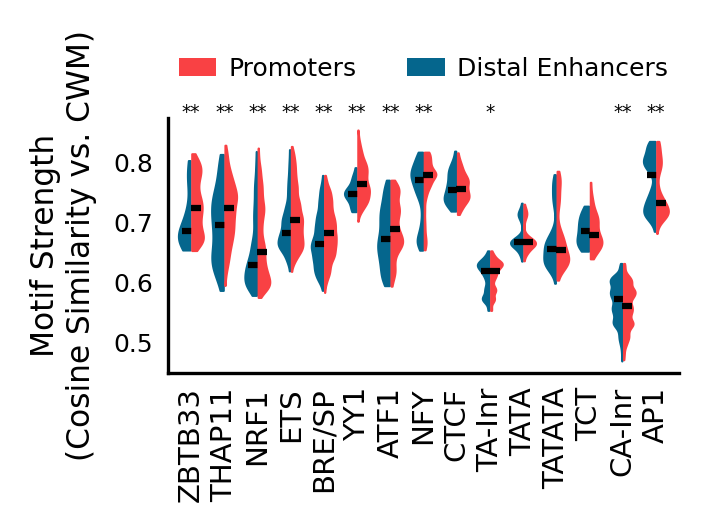

In [70]:
from report_utils import load_modisco_results, compute_per_position_ic
from other_motif_utils import trim_motif_by_ic
from other_motif_utils import trim_motif_by_thresh

from matplotlib.patches import Patch


def score_seq_by_cwm(cwm, seq):
    if type(seq) == str:
        seq = one_hot_encode(seq)
    return np.multiply(seq, cwm).sum() / (np.linalg.norm(seq) * np.linalg.norm(cwm))


def extract_seqs_at_motifs(motif_hits, coords, onehot_seqs, in_window, buffer_width = 200):
        
    assert len(onehot_seqs.shape) == 3 and onehot_seqs.shape[1] == 4, onehot_seqs.shape
    
    def convert_motif_coords_to_seq_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - onehot_seqs.shape[-1]) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))

        return np.array(real_starts), np.array(real_ends)
        
        
    
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"] - 2
    motif_ends = motif_hits["end"] + 2
    
    # if you don't want to trim at all to look more like old results
    #motif_starts = (motif_hits["start"] + motif_hits["end"]) // 2 - 15
    #motif_ends = motif_starts + 30
    
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_seq_coords(coords, coord_indexes,
                                                                  motif_starts, motif_ends)

    # For each seqlet, fetch the sequence
    motif_seqs = []
    for coord_index, motif_start, motif_end, rc in zip(coord_indexes, motif_starts, motif_ends, motif_rcs):
        motif_mid = (motif_start + motif_end) // 2
        if not (motif_mid - buffer_width < 0 or motif_mid + buffer_width > onehot_seqs.shape[-1]):
            seq = onehot_seqs[coord_index, :, motif_start:motif_end]
            if rc:
                seq = seq[::-1, ::-1]
            motif_seqs.append(seq)

    if len(motif_seqs) == 0:
        print("oh no")
        return np.array([])
    
    motif_seqs = np.stack(motif_seqs)
    return motif_seqs


def calc_motif_strengths(modisco_results_path, onehot_seqs, patterns_to_keep,
                         motif_hits, coords, in_window, prof_width=200):

    modisco_results = load_modisco_results(modisco_results_path)
    
    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    cwm_score_list = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        # OLD:
        # need to trim here because the hit caller trimmed
        # but this just trims from 30 to 25
        #cwm_trimmed = trim_motif_by_ic(pattern["contrib_scores"][:], pattern["sequence"][:])
        
        # w new hit caller
        cwm_trimmed = trim_motif_by_thresh(pattern["contrib_scores"][:], trim_threshold=0.2, pad=2)
        cwm_trimmed = cwm_trimmed / np.sum(cwm_trimmed)
        
        
        # if you don't want to trim at all to look more like old results:
        #cwm_trimmed = pattern["contrib_scores"][:] / np.sum(pattern["contrib_scores"][:])
        
        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["motif_index"] == ax_row_i]
        
        motif_seqs = extract_seqs_at_motifs(motif_hits_subset, coords,
                                            onehot_seqs, in_window, buffer_width=prof_width)

        seq_scores = np.array([score_seq_by_cwm(cwm_trimmed, seq.T) for seq in motif_seqs])
        cwm_score_list.append(seq_scores)
        
    return cwm_score_list


def subset_motif_hits_by_ccre(motif_hits, ccre_bools):
    peak_indexes_with_ccre = np.where(ccre_bools)[0]
    return motif_hits[motif_hits["peak_index"].isin(peak_indexes_with_ccre)]


def make_violinplot_halved(violinplot, color, left=False):
    for b in violinplot['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        
        if left:
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], - np.inf, m)
        else:
            # modify the paths to not go further left than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)

        b.set_edgecolor(color)
        b.set_facecolor(color)
        b.set_alpha(1)
        b.set_linewidth(0.5)
        
        
def plot_motif_strengths_by_ccre(modisco_results_path, onehot_seqs,
                                 patterns_to_keep, motif_hits, coords,
                                 in_window, ccre_annots, save_path=None):
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    all_motif_strengths = dict()
    median_motif_strengths = dict()
    
    for annot in ["PLS", "dELS"]:
        motif_hits_for_annot = subset_motif_hits_by_ccre(motif_hits, ccre_annots[annot])

        motif_strengths = calc_motif_strengths(modisco_results_path, np.swapaxes(onehot_seqs,1,2),
                                               patterns_to_keep, motif_hits_for_annot,
                                               coords, in_window)
        
        all_motif_strengths[annot] = np.array(motif_strengths, dtype=object)
        median_motif_strengths[annot] = np.array([np.median(strengths) for strengths in motif_strengths])
    
    plot_order = np.argsort(median_motif_strengths["dELS"] - median_motif_strengths["PLS"])
    num_motifs = len(all_motif_strengths["PLS"])
    
    pvals = []
    for motif_i in range(len(all_motif_strengths["PLS"])):
        mwu_pval = scipy.stats.mannwhitneyu(all_motif_strengths["PLS"][motif_i],
                                         all_motif_strengths["dELS"][motif_i]).pvalue
        if mwu_pval < 0.0001:
            pvals.append("**")
        elif mwu_pval < 0.01:
            pvals.append("*")
        else:
            pvals.append(" ")
            
    pvals = np.array(pvals)[plot_order]
    
    plt.figure(figsize=(2.2,1.1), dpi=300)

    v2 = plt.violinplot(all_motif_strengths["dELS"][plot_order], points=500,
                       positions=np.arange(num_motifs) - 0.03,
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=0.7)
    
    make_violinplot_halved(v2, annots_to_colors["dELS"], left=True)

    plt.scatter(np.arange(num_motifs) - 0.12, median_motif_strengths["dELS"][plot_order],
                marker="_", c="k", s=5, zorder=1)
    
    
    v1 = plt.violinplot(all_motif_strengths["PLS"][plot_order], points=500,
                       positions=np.arange(num_motifs) + 0.02,
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=0.7)
    
    make_violinplot_halved(v1, annots_to_colors["PLS"])

    plt.scatter(np.arange(num_motifs) + 0.14, median_motif_strengths["PLS"][plot_order],
                marker="_", c="k", s=5, zorder=1)
    
    
    # draw pval indicators
    for i in range(len(pvals)):
        plt.text(i, plt.gca().get_ylim()[1], pvals[i],
                 fontsize=4.5, horizontalalignment="center")
    
    
    plt.ylabel("Motif Strength\n(Cosine Similarity vs. CWM)", fontsize=7.5)
    
    plt.xticks(np.arange(num_motifs), np.array(motif_names)[plot_order],
               rotation=90, fontsize=7)
    
    plt.tick_params("both", length=0)
    plt.tick_params("y", labelsize=6)
    plt.xlim(-0.7, num_motifs - 0.3)
    
    plt.gca().spines[["top", "right"]].set_visible(False)

    legend_elements = [Patch(facecolor=annots_to_colors["PLS"], label='Promoters'),
                       Patch(facecolor=annots_to_colors["dELS"], label='Distal Enhancers')]

    plt.legend(handles=legend_elements, fontsize=6, bbox_to_anchor=(0.5, 1.06), ncol=2,
                   loc='lower center', frameon=False, handletextpad=0.5, handlelength=1.5)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()
        
        
plot_motif_strengths_by_ccre(modisco_results_path, onehot_seqs,
                             patterns_to_keep, motif_hits["profile"], coords,
                             in_window, ccre_annots,
                             save_path=figures_dir + "4E_ccre_motif_strengths.png")

# Promoter-Only Model Analysis

In [11]:
from file_configs_promoters_only import PromotersOnlyFoldFilesConfig
from file_configs import FoldFilesConfig

promoters_only_timestamps = ["2024-01-11_04-16-09", "2024-01-11_05-41-04",
                             "2024-01-11_06-46-15", "2024-01-11_07-54-30",
                             "2024-01-11_09-03-11", "2024-01-11_10-25-53",
                             "2024-01-11_11-44-28"]

repeat_timestamps = ["2024-01-16_03-37-23", "2024-01-16_05-24-43",
                     "2024-01-16_07-29-31", "2024-01-16_09-30-37",
                     "2024-01-16_11-11-05", "2024-01-16_13-13-26",
                     "2024-01-16_14-58-16"]

timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]


def load_fold_configs(timestamps, model_type = "strand_merged_umap"):
    data_type = "procap"
    cell_type = "K562"
    
    configs = []
    for i, timestamp in enumerate(timestamps):
        fold = str(i + 1)
        if "promoters_only" in model_type:
            config = PromotersOnlyFoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
        else:
            config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
            
        configs.append(config)
    return configs

promoters_only_fold_configs = load_fold_configs(promoters_only_timestamps,
                                                model_type = "promoters_only_strand_merged_umap")

repeat_fold_configs = load_fold_configs(repeat_timestamps, model_type = "strand_merged_umap_replicate")
original_fold_configs = load_fold_configs(timestamps)

Timestamp: 2024-01-11_04-16-09
Timestamp: 2024-01-11_05-41-04
Timestamp: 2024-01-11_06-46-15
Timestamp: 2024-01-11_07-54-30
Timestamp: 2024-01-11_09-03-11
Timestamp: 2024-01-11_10-25-53
Timestamp: 2024-01-11_11-44-28
Timestamp: 2024-01-16_03-37-23
Timestamp: 2024-01-16_05-24-43
Timestamp: 2024-01-16_07-29-31
Timestamp: 2024-01-16_09-30-37
Timestamp: 2024-01-16_11-11-05
Timestamp: 2024-01-16_13-13-26
Timestamp: 2024-01-16_14-58-16
Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


In [58]:
l = []
for t in range(5):
    l.append((t, t+0.5))
    
a, b = zip(*l)
a,b

((0, 1, 2, 3, 4), (0.5, 1.5, 2.5, 3.5, 4.5))

In [68]:
from scipy.stats import spearmanr

def load_pred_logcounts(config):
    return np.load(config.pred_logcounts_test_path).squeeze()

def load_pred_profiles_flat(config):
    return np.exp(np.load(config.pred_profiles_test_path)).squeeze().flatten()


def get_preds_corrs_one_fold(config1, config2, profile=False):
    if profile:
        preds1 = load_pred_profiles_flat(config1)
        preds2 = load_pred_profiles_flat(config2)
    else:
        preds1 = load_pred_logcounts(config1)
        preds2 = load_pred_logcounts(config2)
    
    assert preds1.shape == preds2.shape
    
    pearson = np.corrcoef(preds1, preds2)[0,1]
    spearman = spearmanr(preds1, preds2).correlation
    return pearson, spearman
    
    
def get_stddevs_corrs_all_folds(configs1, configs2, profile=False):
    corrs = []
    for config1, config2 in zip(configs1, configs2):
        corrs.append(get_preds_corrs_one_fold(config1, config2, profile=profile))
        
    pearsons, spearmans = zip(*corrs)
    return np.std(pearsons), np.std(spearmans) 


def get_pvals_corrs_all_folds(configs1, configs2, replicate_configs2, profile=False):
    corrs_expt = []
    for config1, config2 in zip(configs1, configs2):
        corrs_expt.append(get_preds_corrs_one_fold(config1, config2, profile=profile))
    pearsons_expt, spearmans_expt = zip(*corrs_expt) 
        
    corrs_replicate = []
    for config2, config3 in zip(configs2, replicate_configs2):
        corrs_replicate.append(get_preds_corrs_one_fold(config2, config3, profile=profile))
    pearsons_replicate, spearmans_replicate = zip(*corrs_replicate) 
    
    pearson_pval = scipy.stats.wilcoxon(pearsons_expt, pearsons_replicate).pvalue
    spearman_pval = scipy.stats.wilcoxon(spearmans_expt, spearmans_replicate).pvalue

    return pearson_pval, spearman_pval


def get_preds_corrs_all_folds(configs1, configs2, profile=False):
    preds1 = []
    preds2 = []
    for config1, config2 in zip(configs1, configs2):
        if profile:
            preds1.extend(load_pred_profiles_flat(config1))
            preds2.extend(load_pred_profiles_flat(config2))
        else:
            preds1.extend(load_pred_logcounts(config1))
            preds2.extend(load_pred_logcounts(config2))
    
    preds1 = np.array(preds1)
    preds2 = np.array(preds2)
    assert preds1.shape == preds2.shape
    
    pearson = np.corrcoef(preds1, preds2)[0,1]
    spearman = spearmanr(preds1, preds2).correlation
    return pearson, spearman


def calc_everything(configs1, configs2, replicate_configs2):
    stats = defaultdict(lambda : defaultdict(lambda : defaultdict( lambda : dict())))
    for task in [False, True]:
        if task:
            print("\n===   Profile Task   ===")
        else:
            print("\n===   Counts Task   ===")
    
        print("\nPromoter vs. Original:")
    
        pearson, spearman = get_preds_corrs_all_folds(configs1, configs2, profile=task)
        stats["promoter_vs_original"][task]["corr"]["pearson"] = pearson
        stats["promoter_vs_original"][task]["corr"]["spearman"] = spearman
        print("Corrs:   \t%0.3f\t%0.3f" % (pearson, spearman))
    
        pearson, spearman = get_stddevs_corrs_all_folds(configs1, configs2, profile=task)
        stats["promoter_vs_original"][task]["stddev"]["pearson"] = pearson
        stats["promoter_vs_original"][task]["stddev"]["spearman"] = spearman
        print("Std devs:\t%0.3f\t%0.3f" % (pearson, spearman))
        
        print("\nReplicate vs. Original:")
        
        pearson, spearman = get_preds_corrs_all_folds(replicate_configs2, configs2, profile=task)
        stats["replicate_vs_original"][task]["corr"]["pearson"] = pearson
        stats["replicate_vs_original"][task]["corr"]["spearman"] = spearman
        print("Corrs:   \t%0.3f\t%0.3f" % (pearson, spearman))
    
        pearson, spearman = get_stddevs_corrs_all_folds(replicate_configs2, configs2, profile=task)
        stats["replicate_vs_original"][task]["stddev"]["pearson"] = pearson
        stats["replicate_vs_original"][task]["stddev"]["spearman"] = spearman
        print("Std devs:\t%0.3f\t%0.3f" % (pearson, spearman))

        pearson, spearman = get_pvals_corrs_all_folds(configs1, configs2, replicate_configs2, profile=task)
        stats["pvals"][task]["pearson"] = pearson
        stats["pvals"][task]["spearman"] = spearman
        print("\nP-values:\t%0.3f\t%0.3f" % (pearson, spearman))
        
    return stats

        
promoter_only_model_stats = calc_everything(promoters_only_fold_configs, original_fold_configs, repeat_fold_configs)


===   Counts Task   ===

Promoter vs. Original:
Corrs:   	0.916	0.941
Std devs:	0.015	0.011

Replicate vs. Original:
Corrs:   	0.978	0.971
Std devs:	0.009	0.009

P-values:	0.016	0.031

===   Profile Task   ===

Promoter vs. Original:
Corrs:   	0.881	0.930
Std devs:	0.006	0.006

Replicate vs. Original:
Corrs:   	0.898	0.942
Std devs:	0.006	0.005

P-values:	0.016	0.016


In [75]:
from scipy.stats import spearmanr

def load_deepshaps(config, profile=False):
    if profile:
        scores = np.load(config.profile_onehot_scores_path).sum(axis=1)
    else:
        scores = np.load(config.counts_onehot_scores_path).sum(axis=1)
        
    # slicing to central 1000bp because there probably won't be much past that
    scores = scores[..., in_window // 2 - 500 : in_window // 2 + 500].flatten()
    return scores


def get_attrs_corrs_one_fold(config1, config2, profile=False):
    scores1 = load_deepshaps(config1, profile=profile)
    scores2 = load_deepshaps(config2, profile=profile)
    
    assert scores1.shape == scores2.shape
    
    pearson = np.corrcoef(scores1, scores2)[0,1]
    spearman = spearmanr(scores1, scores2).correlation
    return pearson, spearman
    
    
def get_stddevs_attrs_corrs_all_folds(configs1, configs2, profile=False):
    corrs = []
    for config1, config2 in zip(configs1, configs2):
        corrs.append(get_attrs_corrs_one_fold(config1, config2, profile=profile))
        
    pearsons, spearmans = zip(*corrs)
    return np.std(pearsons), np.std(spearmans) 


def get_pvals_attrs_corrs_all_folds(configs1, configs2, replicate_configs2, profile=False):
    corrs_expt = []
    for config1, config2 in zip(configs1, configs2):
        corrs_expt.append(get_attrs_corrs_one_fold(config1, config2, profile=profile))
    pearsons_expt, spearmans_expt = zip(*corrs_expt) 
        
    corrs_replicate = []
    for config2, config3 in zip(configs2, replicate_configs2):
        corrs_replicate.append(get_attrs_corrs_one_fold(config2, config3, profile=profile))
    pearsons_replicate, spearmans_replicate = zip(*corrs_replicate) 
    
    pearson_pval = scipy.stats.wilcoxon(pearsons_expt, pearsons_replicate).pvalue
    spearman_pval = scipy.stats.wilcoxon(spearmans_expt, spearmans_replicate).pvalue

    return pearson_pval, spearman_pval


def get_attrs_corrs_all_folds(configs1, configs2, profile=False):
    scores1 = []
    scores2 = []
    for config1, config2 in zip(configs1, configs2):
        scores1.extend(load_deepshaps(config1, profile=profile))
        scores2.extend(load_deepshaps(config2, profile=profile))
    
    scores1 = np.array(scores1)
    scores2 = np.array(scores2)
    assert scores1.shape == scores2.shape
    
    pearson = np.corrcoef(scores1, scores2)[0,1]
    spearman = spearmanr(scores1, scores2).correlation
    return pearson, spearman


def calc_everything_scores(configs1, configs2, replicate_configs2):
    stats = defaultdict(lambda : defaultdict(lambda : defaultdict( lambda : dict())))
    for task in [False, True]:
        if task:
            print("\n===   Profile Task   ===")
        else:
            print("\n===   Counts Task   ===")
    
        print("\nPromoter vs. Original:")
    
        pearson, spearman = get_attrs_corrs_all_folds(configs1, configs2, profile=task)
        stats["promoter_vs_original"][task]["corr"]["pearson"] = pearson
        stats["promoter_vs_original"][task]["corr"]["spearman"] = spearman
        print("Corrs:   \t%0.3f\t%0.3f" % (pearson, spearman))
    
        pearson, spearman = get_stddevs_attrs_corrs_all_folds(configs1, configs2, profile=task)
        stats["promoter_vs_original"][task]["stddev"]["pearson"] = pearson
        stats["promoter_vs_original"][task]["stddev"]["spearman"] = spearman
        print("Std devs:\t%0.3f\t%0.3f" % (pearson, spearman))
        
        print("\nReplicate vs. Original:")
        
        pearson, spearman = get_attrs_corrs_all_folds(replicate_configs2, configs2, profile=task)
        stats["replicate_vs_original"][task]["corr"]["pearson"] = pearson
        stats["replicate_vs_original"][task]["corr"]["spearman"] = spearman
        print("Corrs:   \t%0.3f\t%0.3f" % (pearson, spearman))
    
        pearson, spearman = get_stddevs_attrs_corrs_all_folds(replicate_configs2, configs2, profile=task)
        stats["replicate_vs_original"][task]["stddev"]["pearson"] = pearson
        stats["replicate_vs_original"][task]["stddev"]["spearman"] = spearman
        print("Std devs:\t%0.3f\t%0.3f" % (pearson, spearman))

        pearson, spearman = get_pvals_attrs_corrs_all_folds(configs1, configs2, replicate_configs2, profile=task)
        stats["pvals"][task]["pearson"] = pearson
        stats["pvals"][task]["spearman"] = spearman
        print("\nP-values:\t%0.3f\t%0.3f" % (pearson, spearman))
        
    return stats

        
promoter_only_model_stats_scores = calc_everything_scores(promoters_only_fold_configs,
                                                          original_fold_configs,
                                                          repeat_fold_configs)


===   Counts Task   ===

Promoter vs. Original:
Corrs:   	0.692	0.659
Std devs:	0.033	0.030

Replicate vs. Original:
Corrs:   	0.839	0.805
Std devs:	0.024	0.022

P-values:	0.016	0.016

===   Profile Task   ===

Promoter vs. Original:
Corrs:   	0.840	0.726
Std devs:	0.010	0.021

Replicate vs. Original:
Corrs:   	0.875	0.774
Std devs:	0.006	0.010

P-values:	0.016	0.016


In [76]:
def print_table(stats, stats_scores):
    rownames = ["Counts Predictions", "Profile Predictions",
                "Counts Contribution Scores", "Profile Contribution Scores"]
    
    # TODO: add deepshap scores to this as 2 new rows
    row1 = []
    row2 = []
    row3 = []
    row4 = []
    for comparison in ["replicate_vs_original", "promoter_vs_original"]:
        for correlation_type in ["pearson", "spearman"]:
            for corr_or_stddev in ["corr", "stddev"]:
                # counts, then profile
                row1.append(stats[comparison][False][corr_or_stddev][correlation_type])
                row2.append(stats[comparison][True][corr_or_stddev][correlation_type])
                
                row3.append(stats_scores[comparison][False][corr_or_stddev][correlation_type])
                row4.append(stats_scores[comparison][True][corr_or_stddev][correlation_type])
                
    rows_data = [row1, row2, row3, row4]
    
    for row_i, (row_data, rowname) in enumerate(zip(rows_data, rownames)):
        row_means = [val for col_i, val in enumerate(row_data) if col_i % 2 == 0]
        row_stddevs = [val for col_i, val in enumerate(row_data) if col_i % 2 == 1]
        
        row_as_str = [rowname]
        for mean, stddev in zip(row_means, row_stddevs):
            row_as_str.append("%0.3f" % (mean) + " (%0.3f)" % (stddev))
        
        row_as_str = " & ".join(row_as_str)
        
        if row_i < len(rows_data) - 1:
            print(row_as_str + r' \\')
        else:
            print(row_as_str + r'\label{Tab2}\\')

print_table(promoter_only_model_stats, promoter_only_model_stats_scores)

Counts Predictions & 0.978 (0.009) & 0.971 (0.009) & 0.916 (0.015) & 0.941 (0.011) \\
Profile Predictions & 0.898 (0.006) & 0.942 (0.005) & 0.881 (0.006) & 0.930 (0.006) \\
Counts Contribution Scores & 0.839 (0.024) & 0.805 (0.022) & 0.692 (0.033) & 0.659 (0.030) \\
Profile Contribution Scores & 0.875 (0.006) & 0.774 (0.010) & 0.840 (0.010) & 0.726 (0.021)\label{Tab2}\\


In [29]:
def get_pred_counts_all_folds(configs, spearman=False):
    pred_counts = []
    for config in configs:
        loaded_preds = np.load(config.pred_logcounts_test_path).squeeze()
        pred_counts.extend(np.exp(loaded_preds))
    return np.array(pred_counts)

promoters_only_pred_counts = get_pred_counts_all_folds(promoters_only_fold_configs)
original_pred_counts = get_pred_counts_all_folds(original_fold_configs)

In [30]:
def get_sort_order_test_sets(cell_type, model_type, data_type):
    # the way I loaded in the test sets fold-by-fold,
    # the examples are not in the same order as the all_peaks_bed file order
    # so this function figures out how to reorder the test set data
    
    test_coords = []
    
    for fold_0_index, timestamp in enumerate(timestamps):
        fold = str(fold_0_index + 1)
        config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
        
        test_coords.extend(load_coords(config.test_peak_path, in_window))
        
    # this contains the same coords at test_coords, but in the correct order this time
    merged_config = MergedFilesConfig(cell_type, model_type, data_type)
    all_coords = load_coords(merged_config.all_peak_path, in_window)
    
    sort_order = [test_coords.index(coord) for coord in all_coords]
    assert np.all(np.array(all_coords) == np.array(test_coords)[sort_order])
    
    return sort_order

sort_order = get_sort_order_test_sets(cell_type, model_type, data_type)
sorted_promoters_only_pred_counts = promoters_only_pred_counts[sort_order]
sorted_original_pred_counts = original_pred_counts[sort_order]

Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


0.9163440714861799


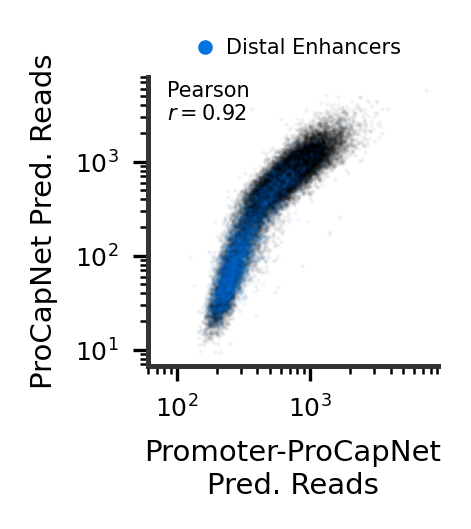

In [44]:
from matplotlib.lines import Line2D

def plot_counts_scatter(promoter_model_counts, normal_model_counts, color_by,
                             title = None, save_path = None, xlabel = None, ylabel = None):

    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}
    
    promoter_model_counts = promoter_model_counts.squeeze().flatten()
    normal_model_counts = normal_model_counts.squeeze().flatten()
    
    assert promoter_model_counts.shape == normal_model_counts.shape
    
    pearson_r = np.corrcoef(np.log(promoter_model_counts),
                            np.log(normal_model_counts))[0,1]
    
    plot_params = {
        "xtick.labelsize": 6,
        "ytick.labelsize": 6
    }
    plt.rcParams.update(plot_params)

    plt.figure(figsize=(1.25,1.25), dpi=300)

    colors = np.array(["#000000" for _ in range(len(color_by))])
    colors[color_by] = annots_to_colors["dELS"]
    plt.scatter(promoter_model_counts[~color_by], normal_model_counts[~color_by], c="k",
                alpha = 0.05, s = 1, linewidths=0)
    plt.scatter(promoter_model_counts[color_by], normal_model_counts[color_by], c="#0174DF",
                alpha = 0.05, s = 1, linewidths=0, label="Distal\nEnhancers")

    plt.semilogy()
    plt.semilogx()

    max_lim = max(plt.gca().get_xlim()[1], plt.gca().get_ylim()[1])
    min_lim = min(plt.gca().get_xlim()[0], plt.gca().get_ylim()[0])
    #plt.ylim(min_lim, max_lim)
    plt.xlim(60, plt.gca().get_xlim()[1])

    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=7)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=7)

    if pearson_r is not None:
        print(pearson_r)
        plt.text(60 * 1.4, max_lim * 0.31,
                 "Pearson\n" + r'$r = %0.2f$' % pearson_r,
                 fontsize=5)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.legend(handles=[Line2D([0], [0], marker='o', color='w',
                               label='Distal Enhancers', markeredgewidth=0,
                          markerfacecolor='#0174DF', markersize=3.5)],
               fontsize=5, loc="upper center", handletextpad=0, frameon=False, 
               bbox_to_anchor=(0.5,1.2))
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        
    #plt.gca().set_aspect('equal', 'box')
    plt.show()
    
plot_counts_scatter(sorted_promoters_only_pred_counts,
                    sorted_original_pred_counts,
                    ccre_annots["dELS"],
                   xlabel = "Promoter-ProCapNet\nPred. Reads",
                   ylabel = "ProCapNet Pred. Reads",
                    save_path = figures_dir + "4_promoters_only_model_preds_scatter.png")  

## Motif Co-occurrence Plots

In [53]:
def get_motif_jaccard_matrix(peak_hit_counts):
    peak_hit_counts = (peak_hit_counts > 0) * 1
    num_motifs = peak_hit_counts.shape[1]
    
    jaccards = np.zeros((num_motifs, num_motifs))
    for i in range(num_motifs):
        motif_i_peak_hits = peak_hit_counts[:, i]
        for j in range(i + 1, num_motifs):
            motif_j_peak_hits = peak_hit_counts[:, j]
            
            intersection = np.dot(motif_i_peak_hits, motif_j_peak_hits)
            union = np.sum((motif_i_peak_hits + motif_j_peak_hits) > 0)
            jaccards[i, j] = intersection / union
            jaccards[j, i] = jaccards[i, j]
            
    return jaccards

def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix
    

promoter_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts["profile"][ccre_annots["PLS"]])
enhancer_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts["profile"][ccre_annots["dELS"]])
combo_jaccard_matrix = combine_two_symmetric_matrices(promoter_motif_jaccard_matrix,
                                                      enhancer_motif_jaccard_matrix)

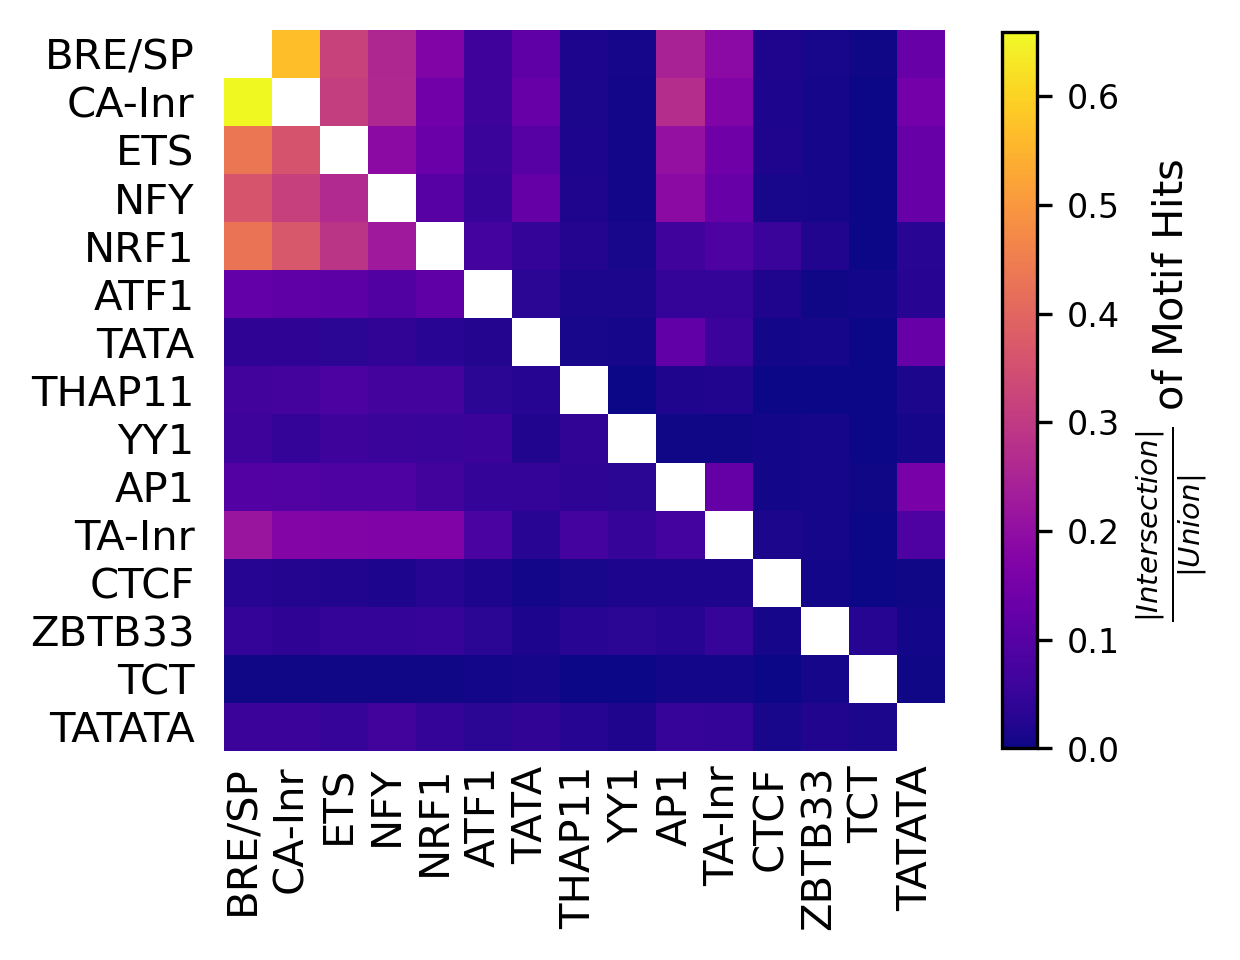

In [54]:
from plot_utils import get_continuous_cmap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def get_upper_right_highlight_coords(n_rows):
    # assuming n_rows = n_cols
    # want (5.5, 0.5), (4.5, 0.5), (4.5, 1.5), ..., (0.5, 5.5)
    
    curr_x = 0.5
    curr_y = -0.5
    
    coords_list = [(curr_x, curr_y)]
    while curr_x < n_rows - 0.5:
        curr_y += 1
        coords_list.append((curr_x, curr_y))
        curr_x += 1
        coords_list.append((curr_x, curr_y))
        
    coords_list.append((n_rows - 0.5, -0.5))
    coords_list.append(coords_list[0])  # back to start
    
    return np.array(coords_list)


def plot_jaccard_matrix(jaccard_matrix, inds=None):
    num_motifs = jaccard_matrix.shape[0]
    
    if inds is not None:
        assert len(inds) == num_motifs, inds
        jaccard_matrix = jaccard_matrix[inds][:, inds]
        ticklabels = [k + 1 for k in inds]
    else:
        ticklabels = range(num_motifs)
    
    ticklabels = [motif_names[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(jaccard_matrix, cmap="plasma")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label=r'$\frac{|Intersection|}{|Union|}$ of Motif Hits',
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    
    
plot_jaccard_matrix(combo_jaccard_matrix)

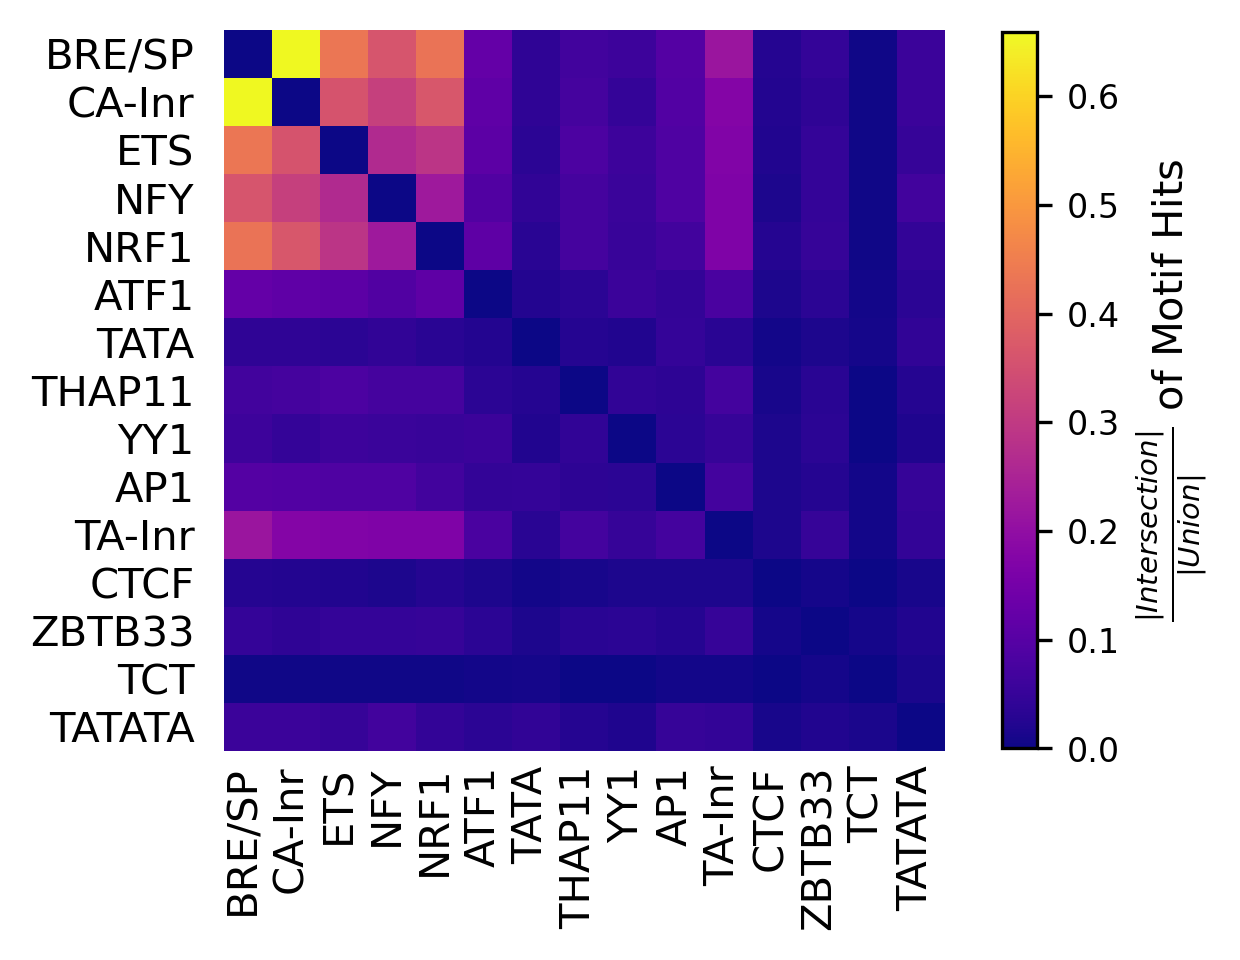

In [55]:
# sanity check which corner is the promoters corner:
plot_jaccard_matrix(promoter_motif_jaccard_matrix)

In [106]:
def plot_motif_cooccurrence(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  #/ peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :]) * peak_hit_counts.shape[0] ####

    combo_matrix = combine_two_symmetric_matrices(motif_frac_matrix, motif_cooccur_fracs)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="plasma")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Peaks w/ Both Motifs",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.title("Expected (bottom) vs. Observed (top)\nMotif Co-occurence")
    plt.show()
    
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["PLS"]])
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["dELS"]])

NameError: name 'motif_keys_to_labels' is not defined

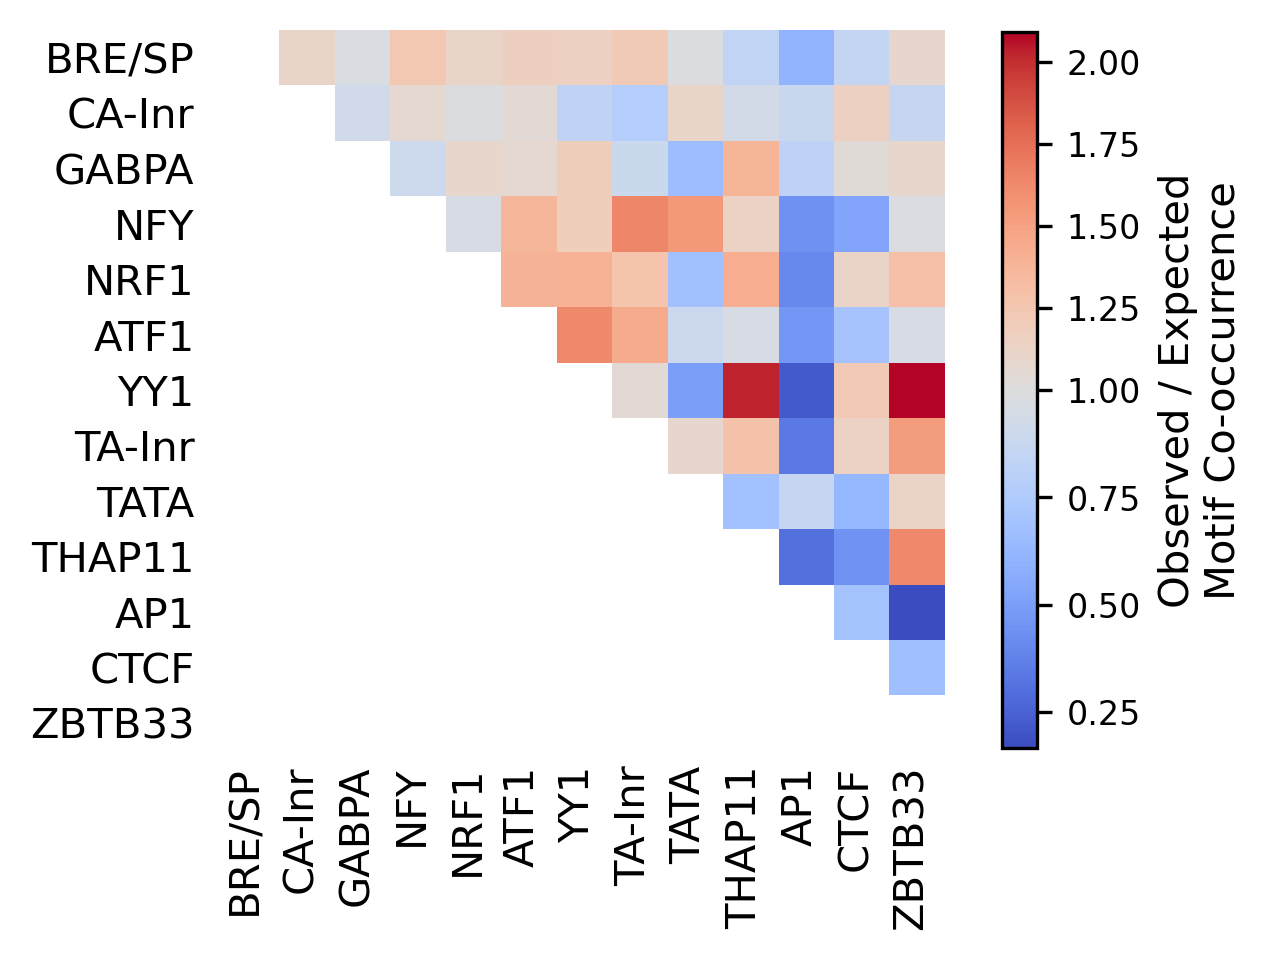

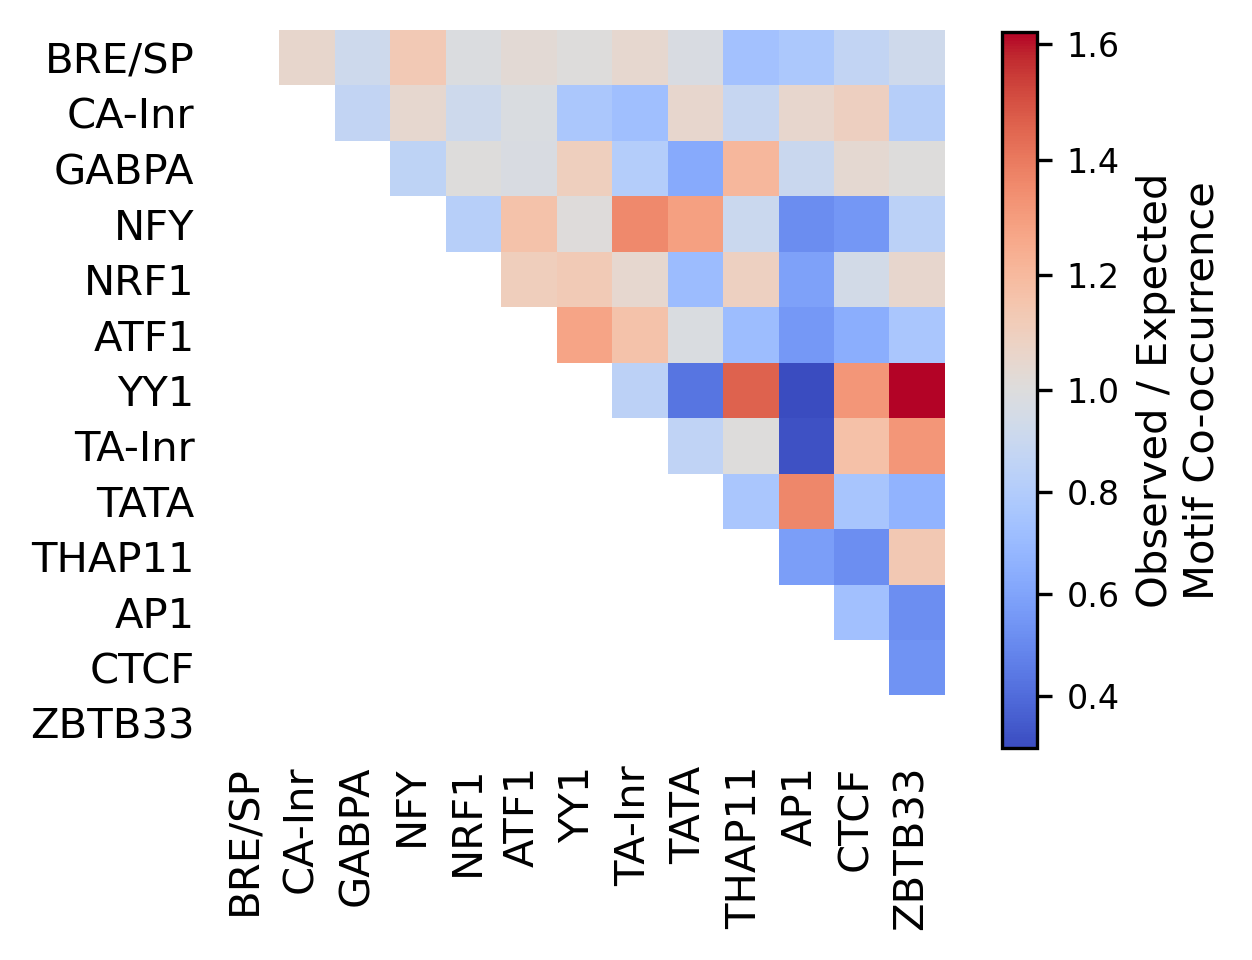

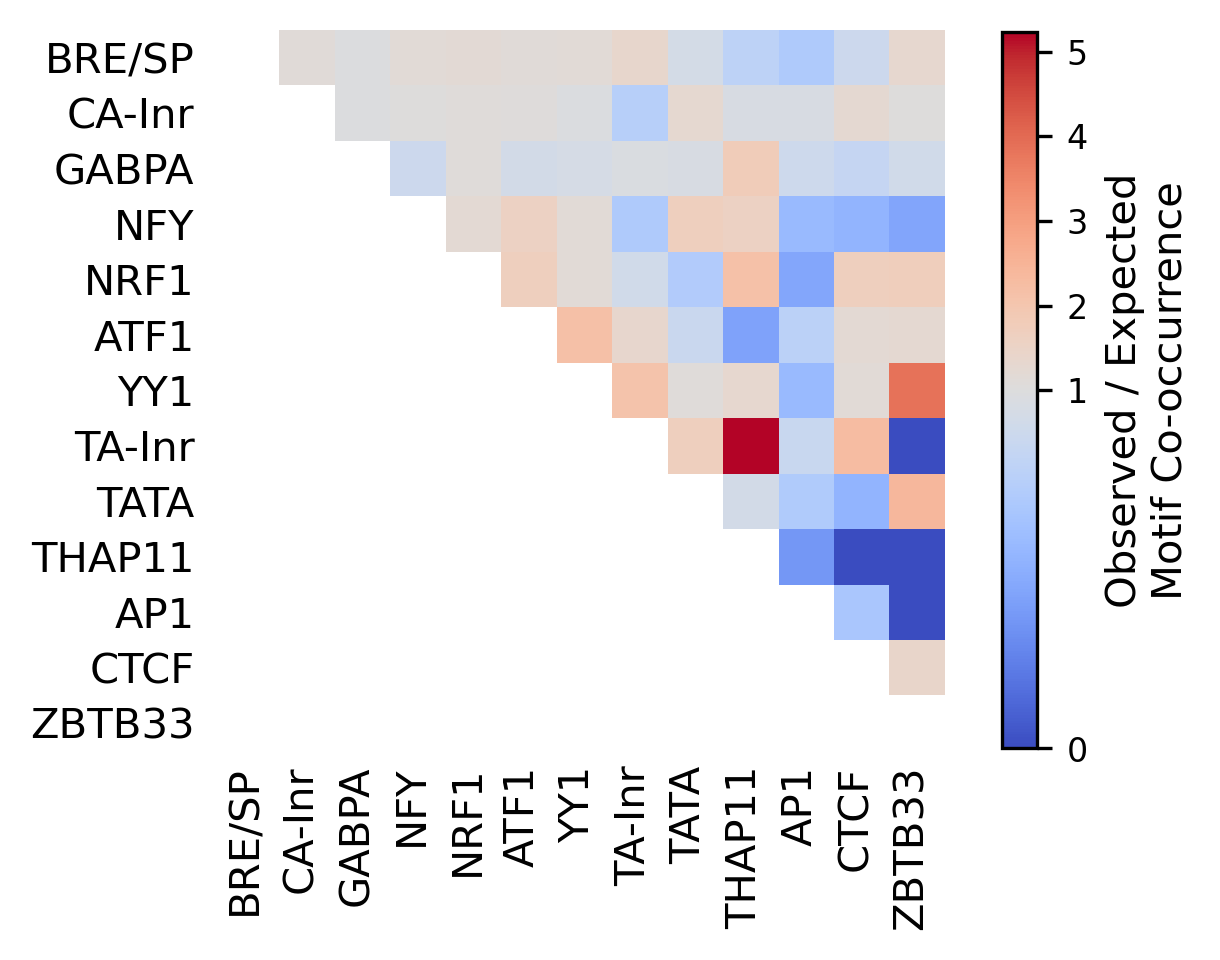

In [155]:
from collections import defaultdict
from matplotlib import colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))



def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix


def plot_motif_cooccurrence(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  / peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :])

    motif_cooccur_enrichment = motif_cooccur_fracs / motif_frac_matrix
    
    combo_matrix = combine_two_symmetric_matrices(np.full_like(motif_frac_matrix, np.nan),
                                                  motif_cooccur_enrichment)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="coolwarm", norm=colors.TwoSlopeNorm(vmin=np.min(combo_matrix[~np.isnan(combo_matrix)]),
                                                                       vcenter=1.,
                                        vmax=np.max(combo_matrix[~np.isnan(combo_matrix)])))
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Observed / Expected\nMotif Co-occurrence",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"])
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["PLS"]])
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["dELS"]])

/tmp/ipykernel_14713/1146164121.py:57: RuntimeWarning: divide by zero encountered in log10
  neg_log_pvals = - np.log10(compute_cooccurrence_pvals(peak_hit_counts))


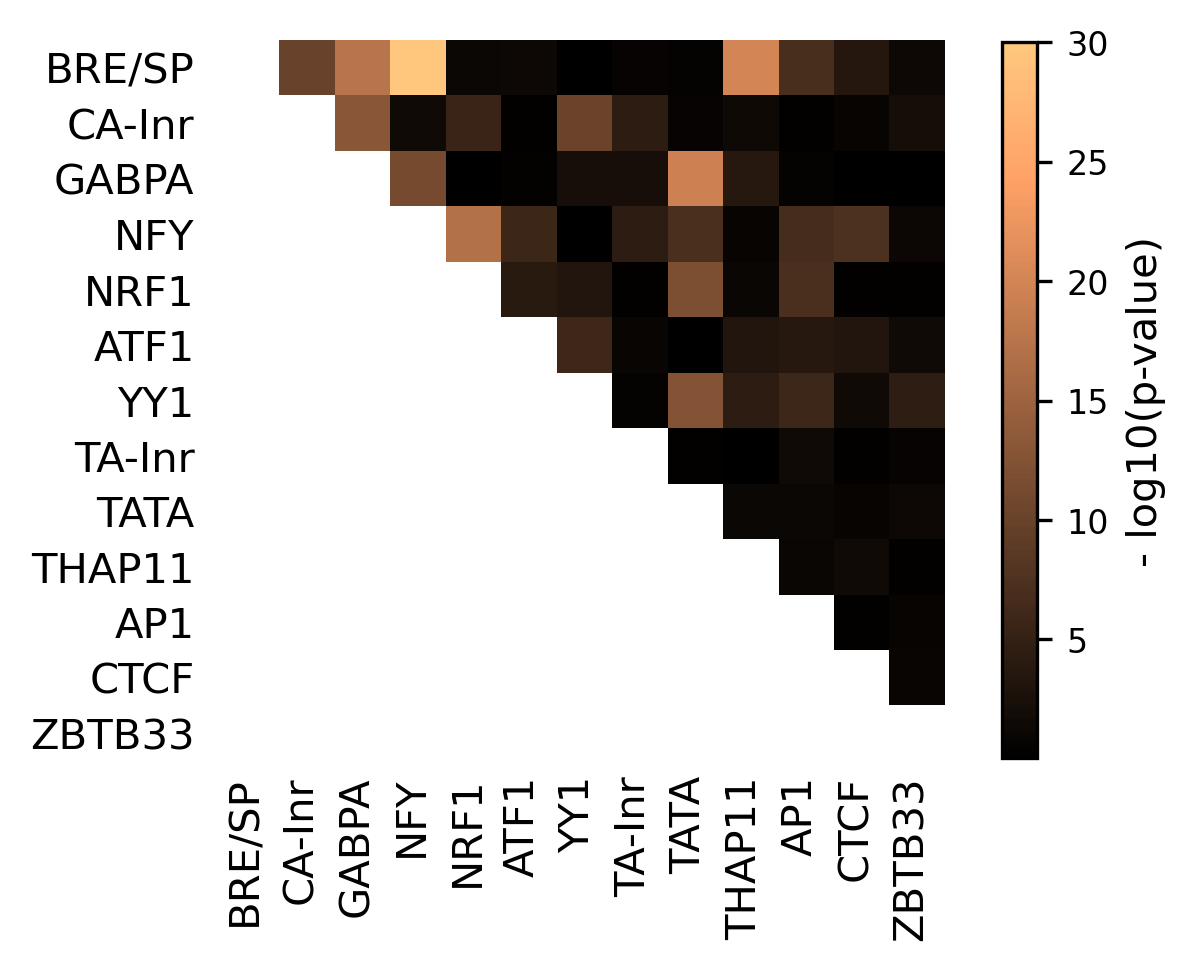

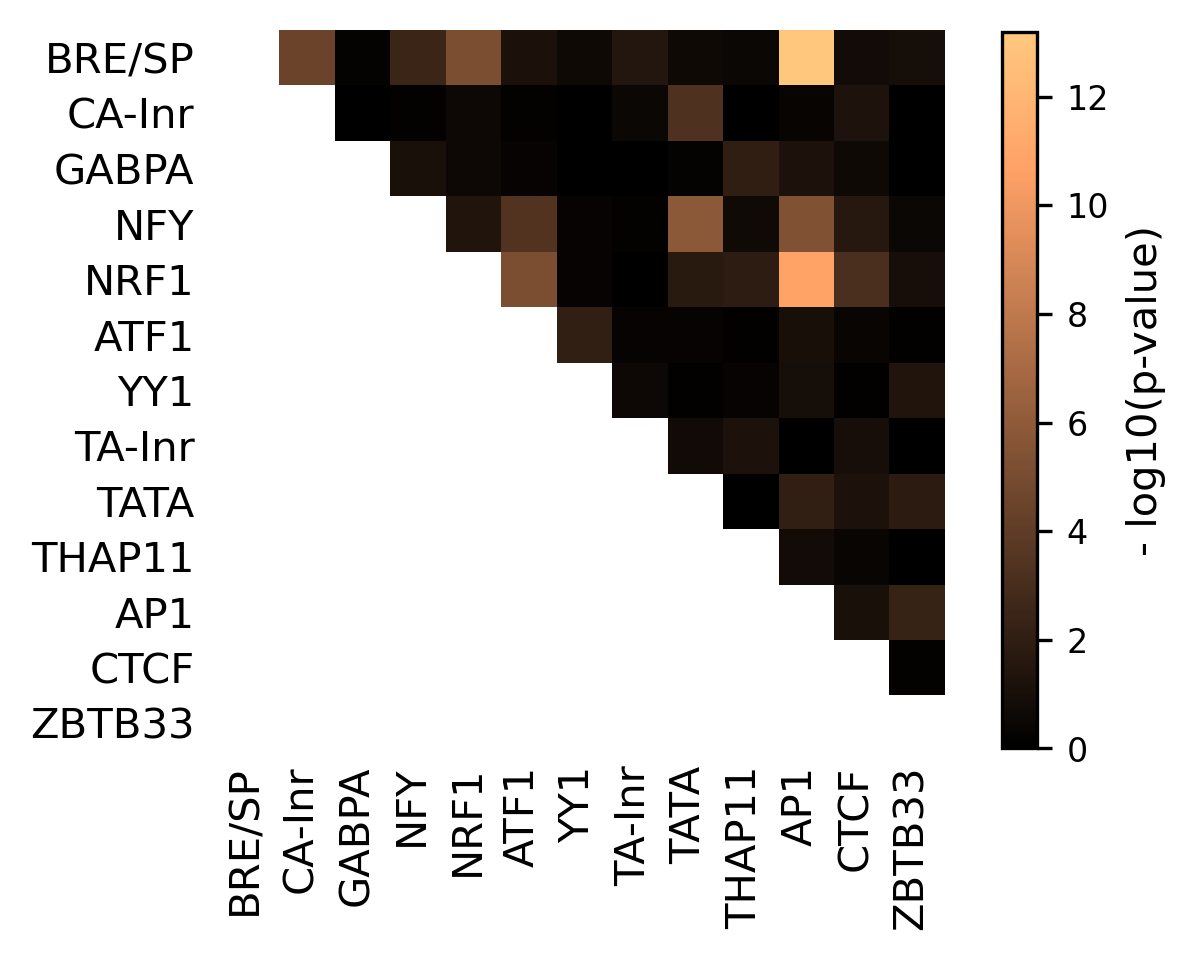

In [156]:
import scipy

def compute_cooccurrence_pvals(peak_hit_counts):
    """
    Given the number of motif hits in each peak, computes p-value of
    co-occurrence for each pair of motifs, including self pairs.
    Returns an M x M array of p-values for the M motifs.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_peaks, num_motifs = peak_hit_counts.shape
    
    pvals = np.ones((num_motifs, num_motifs))
    
    # Significance is based on a Fisher's exact test. If the motifs were
    # present in peaks randomly, we'd independence of occurrence.
    # For self-co-occurrence, the null model is not independence, but
    # collisions
    for i in range(num_motifs):
        for j in range(i):
            pair_counts = peak_hit_indicators[:, [i, j]]
            peaks_with_1 = pair_counts[:, 0] == 1
            peaks_with_2 = pair_counts[:, 1] == 1
            # Contingency table (universe is set of all peaks):
            #              no motif 1  |  has motif 1
            # no motif 2       A       |      B
            # -------------------------+--------------
            # has motif 2      C       |      D
            # The Fisher's exact test evaluates the significance of the
            # association between the two classifications
            cont_table = np.array([
                [
                    np.sum(~(peaks_with_1) & (~peaks_with_2)),
                    np.sum(peaks_with_1 & (~peaks_with_2))
                ],
                [
                    np.sum(~(peaks_with_1) & peaks_with_2),
                    np.sum(peaks_with_1 & peaks_with_2)
                ]
            ])
            pval = scipy.stats.fisher_exact(
                cont_table, alternative="two-sided"
            )[1]
            pvals[i, j] = pval
            pvals[j, i] = pval

        # Self-co-occurrence: Poissonize balls in bins
        # Expected number of collisions (via linearity of expectations):
        num_hits = np.sum(peak_hit_indicators[:, i])  # number of "balls"
        expected_collisions = num_hits * (num_hits - 1) / (2 * num_peaks)
        num_collisions = np.sum(peak_hit_counts[:, i] >= 2)
        pval = 1 - scipy.stats.poisson.cdf(num_collisions, mu=expected_collisions)
        pvals[i, i] = pval
    
    return pvals

def plot_pvals(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    neg_log_pvals = - np.log10(compute_cooccurrence_pvals(peak_hit_counts))
    
    #neg_log_pvals[neg_log_pvals < 5] = np.nan
    
    matrix_to_plot = combine_two_symmetric_matrices(np.full_like(neg_log_pvals, np.nan),
                                                    neg_log_pvals)
    
    num_motifs = len(motif_keys_to_labels)
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(matrix_to_plot, cmap="copper")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="- log10(p-value)",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    

plot_pvals(motif_hit_counts["profile"][ccre_annots["PLS"]])
plot_pvals(motif_hit_counts["profile"][ccre_annots["dELS"]])

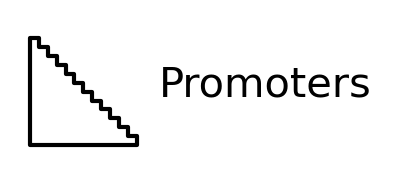

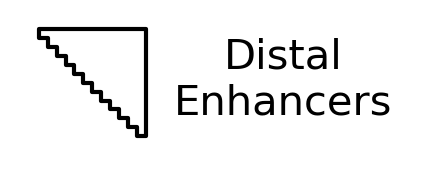

In [238]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def drew_legend_for_heatmap(combo_jaccard_matrix, promoters=True):
    dim = len(combo_jaccard_matrix)
    
    blank_map = np.full((dim, dim), np.nan)
    
    plt.figure(figsize=(0.5,0.5), dpi=300)
    cmap = get_continuous_cmap(["#3B1F68", "#5F31A6", "#B197DA"])  # doesn't matter
    cmap.set_bad('white',1.)
    plt.imshow(blank_map, cmap=cmap)
    
    ax = plt.gca()
    
    upper_right_highlight_coords = get_upper_right_highlight_coords(dim)
    if promoters:
        upper_right_highlight_coords = upper_right_highlight_coords[:, ::-1]
    upper_right_highlight = Polygon(upper_right_highlight_coords)
    ax.add_collection(PatchCollection([upper_right_highlight],
                                      color="k", facecolor="none",
                                      linewidth=1, clip_on=False))
    
    if promoters:
        ax.text(dim * 2, dim -5,
                "Promoters",
                ha="center", va="bottom", color="k", fontsize=10)
    else:
        ax.text(dim * 2+2, dim - 3,
                "Distal\nEnhancers",
                ha="center", va="bottom", color="k", fontsize=10)
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    
    
drew_legend_for_heatmap(combo_jaccard_matrix, promoters=True)
drew_legend_for_heatmap(combo_jaccard_matrix, promoters=False)